In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 

[dorahacks github repo](https://github.com/dorahacksglobal/qc-classifier)

<center> $a_ib_i$ circuit </center>

|     |a = 0|a = 1|
|:----|-----|-----|
|b = 0|<img src="https://github.com/dorahacksglobal/quantum-randomness-generator/blob/d45624616a57a8b98da2ad85b4aa254855ce1202/README_pic/a0b0_circuit.png?raw=true" width="400"/>|<img src="https://github.com/dorahacksglobal/quantum-randomness-generator/blob/d45624616a57a8b98da2ad85b4aa254855ce1202/README_pic/a1b0_circuit.png?raw=true" width="400"/>|
|b = 1|<img src="https://github.com/dorahacksglobal/quantum-randomness-generator/blob/d45624616a57a8b98da2ad85b4aa254855ce1202/README_pic/a0b1_circuit.png?raw=true" width="400"/>|<img src="https://github.com/dorahacksglobal/quantum-randomness-generator/blob/d45624616a57a8b98da2ad85b4aa254855ce1202/README_pic/a1b1_circuit.png?raw=true" width="400"/>|

### functions for analysis

In [2]:
# function to produce a list of windows from a word
# window size is n, and stepping dx at a time
# assumed: len(word) > n > dx
def window(word, n=1, dx=1):
    return [
        word[i : i + n]
        for i in range(0, len(word) - n + 1, dx)
    ]


In [22]:
# xor between two bitstrings (str, /[01]*/)
def logic_xor(a, b):
    return ''.join([
        str(i)
        for i in np.array([int(x) for x in a]) ^ np.array([int(x) for x in b])
    ])

logic_xor('1010', '1100')

'0110'

In [23]:
# create sequential XOR series
# Series(1,2,...,n) -> Series(1^2, 2^3, ..., n-1^n)
def reduce1(s):
    return pd.Series([
        logic_xor(*bti)
        for bti in window(s, 2, 2)
    ])


## [ 2-qubit bell pair generator ](AI_2qubits_training_data.txt)?

### read & process data

In [5]:
# read file with space separator and add column names
df = pd.read_csv(
    'AI_2qubits_training_data.txt',
    delimiter = ' ',
    names = ['bitstring', 'label']
)
df

,bitstring,label
0,0100111111110000000000101110100011011011110000...,1
1,0110011011110001111110001000001110011110011100...,1
2,1110100101110111111101101100110101111101010001...,1
3,1101000011100100011101001110111100011110100111...,1
4,0000000000100101001101100000101000101110110001...,1
...,...,...
13995,1111010111001101111011010000011011100100111100...,4
13996,0101100011000001111011001010001101110100000101...,4
13997,1100111100111101111000001100010010001111111011...,4
13998,1101110000111110011101001100111100001011000010...,4


In [6]:
# concatenate(squash) all shots by machine label
dfs = df.groupby('label').bitstring.apply(''.join)
dfs

label
1    0100111111110000000000101110100011011011110000...
2    0110011100111011110010111100100101000101101111...
3    1001000011110111101011010100111001000001001100...
4    0011011101000100100001010011110010000001000111...
Name: bitstring, dtype: object

### create windows

In [21]:
# split the bitstrings into windows per estimated observation
window_len  = 4
window_size = 4

bitstrings = {
    label : df.bitstring.reset_index().bitstring
    for (label, df) in dfs.apply(lambda x: window(x, window_len, window_size)).explode().reset_index().groupby('label')
}

bitstrings

{1: 0        0100
 1        1111
 2        1111
 3        0000
 4        0000
          ... 
 49995    1110
 49996    0000
 49997    0101
 49998    0100
 49999    0100
 Name: bitstring, Length: 50000, dtype: object,
 2: 0        0110
 1        0111
 2        0011
 3        1011
 4        1100
          ... 
 49995    0101
 49996    0101
 49997    0010
 49998    1101
 49999    1011
 Name: bitstring, Length: 50000, dtype: object,
 3: 0        1001
 1        0000
 2        1111
 3        0111
 4        1010
          ... 
 49995    1011
 49996    1001
 49997    0011
 49998    1100
 49999    1100
 Name: bitstring, Length: 50000, dtype: object,
 4: 0         0011
 1         0111
 2         0100
 3         0100
 4         1000
           ... 
 199995    0010
 199996    1111
 199997    1100
 199998    0011
 199999    0111
 Name: bitstring, Length: 200000, dtype: object}

In [8]:
# xor consecutive windows
bitstrings_xor = {
    i: reduce1(b)
    for (i, b) in bitstrings.items()
}

### testing

In [9]:
# function to run stat tests
def test_mat(mat):
    from itertools import combinations as comb
    
    for (x, y) in comb(range(4), 2):

        test1 = sp.stats.mannwhitneyu(
            x = mat[x + 1],
            y = mat[y + 1],
        )
        
        test2 = None
        # test2 = sp.stats.brunnermunzel(
        #     x = mat[x + 1],
        #     y = mat[y + 1],
        #     distribution = 'normal'
        # )
        
        print(x+1, y+1, test1, test2)

In [25]:
# make a table: machine × bitstring
def counts_mat_maker(series_map):
    ans = pd.DataFrame()
    for (i, b) in series_map.items():
        cts = b.value_counts()
        cts = cts.rename(i)
        ans = pd.concat([ans, cts], axis=1)
    return ans

In [24]:
counts_mat = counts_mat_maker(bitstrings)
counts_mat

,1,2,3,4
1111,5391,6105,3281,21864
1101,4309,4645,2769,12745
0111,4221,4578,2967,12774
0011,3857,3906,3540,21690
1100,3767,3819,3503,21435
0101,3446,3394,2380,7534
0001,3029,3079,3050,12531
0100,2972,2821,3080,12319
1110,2897,2940,3283,10072
1011,2883,2946,3187,10260


In [11]:
counts_xor_mat = counts_mat_maker(bitstrings_xor)
counts_xor_mat

,1,2,3,4
0010,1742,1784,1616,6094
0100,1657,1579,1540,6140
1100,1634,1568,1560,7485
0000,1629,1876,1576,7488
0011,1610,1611,1541,7343
1010,1604,1678,1591,5163
1000,1584,1675,1561,6399
0001,1551,1615,1524,6182
1011,1544,1439,1545,6269
1110,1532,1551,1584,6309


In [12]:
test_mat(counts_mat)

1 2 MannwhitneyuResult(statistic=131.0, pvalue=0.9249325745653402) None
1 3 MannwhitneyuResult(statistic=115.0, pvalue=0.6375611304257702) None
1 4 MannwhitneyuResult(statistic=1.0, pvalue=1.8638894005781834e-06) None
2 3 MannwhitneyuResult(statistic=111.0, pvalue=0.5340292284243271) None
2 4 MannwhitneyuResult(statistic=3.0, pvalue=2.7018981894818364e-06) None
3 4 MannwhitneyuResult(statistic=0.0, pvalue=1.5449101737495915e-06) None


In [13]:
test_mat(counts_xor_mat)

1 2 MannwhitneyuResult(statistic=134.5, pvalue=0.8210653399253179) None
1 3 MannwhitneyuResult(statistic=121.5, pvalue=0.8210653399253179) None
1 4 MannwhitneyuResult(statistic=0.0, pvalue=1.541512705218063e-06) None
2 3 MannwhitneyuResult(statistic=119.5, pvalue=0.7630035309380625) None
2 4 MannwhitneyuResult(statistic=0.0, pvalue=1.5449101737495915e-06) None
3 4 MannwhitneyuResult(statistic=0.0, pvalue=1.5449101737495915e-06) None


### plots of dists

In [26]:
# plot 4 sets at a time
def plot4b(bitstrings, mapping):
    n = len(bitstrings)
    fig, axs = plt.subplots(1, n, sharey=True, tight_layout=True, figsize=(3*n, 4))
    for (i, b) in bitstrings.items():
        prop = mapping(b).sort_index()
        prop.plot.bar(ax = axs[i - 1], title = str(i), legend = False, width=1)
        # axs[i-1].set_xticklabels(bit)

In [15]:
# why no norm, numpy?
def np_norm(x, l=2):
    return x / np.power(np.sum(np.power(x, l)), 1/l)

np.norm = np_norm

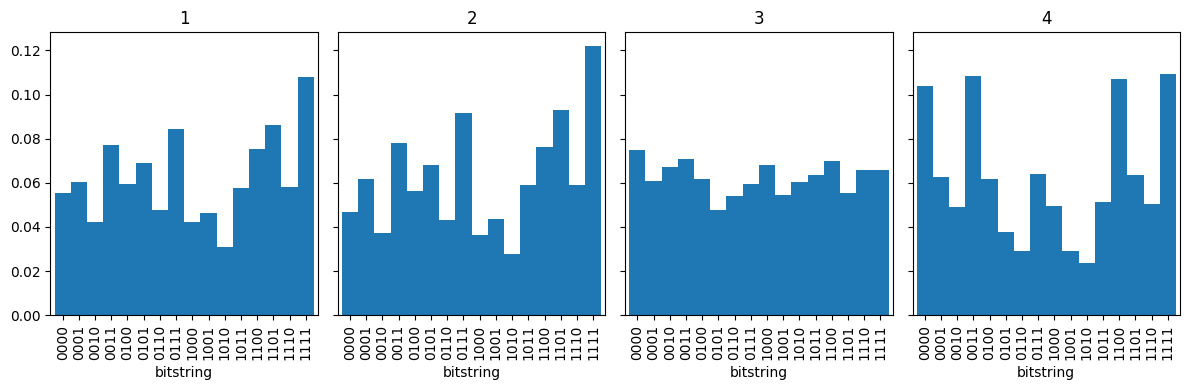

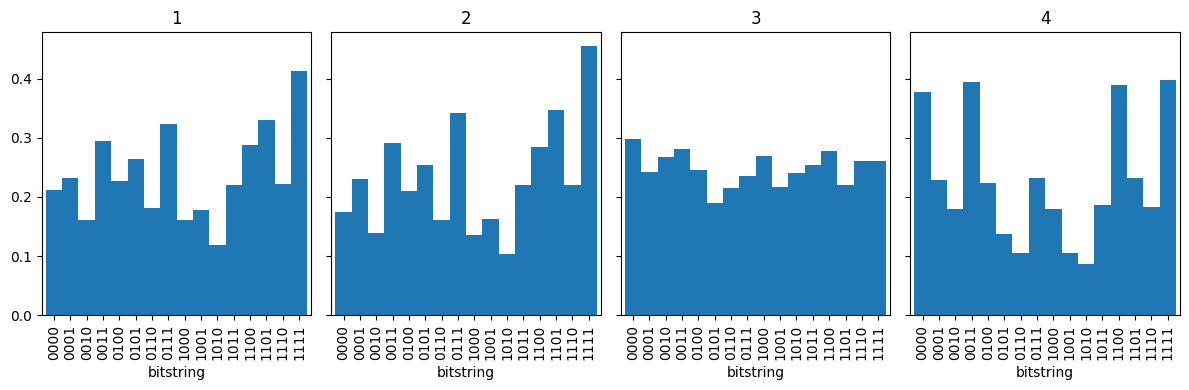

In [27]:
# plot proportions

# probability sum = 1 vector
plot4b(bitstrings, lambda s: np.norm(s.value_counts(), l=1))

# "normal" vector
plot4b(bitstrings, lambda s: np.norm(s.value_counts(), l=2))

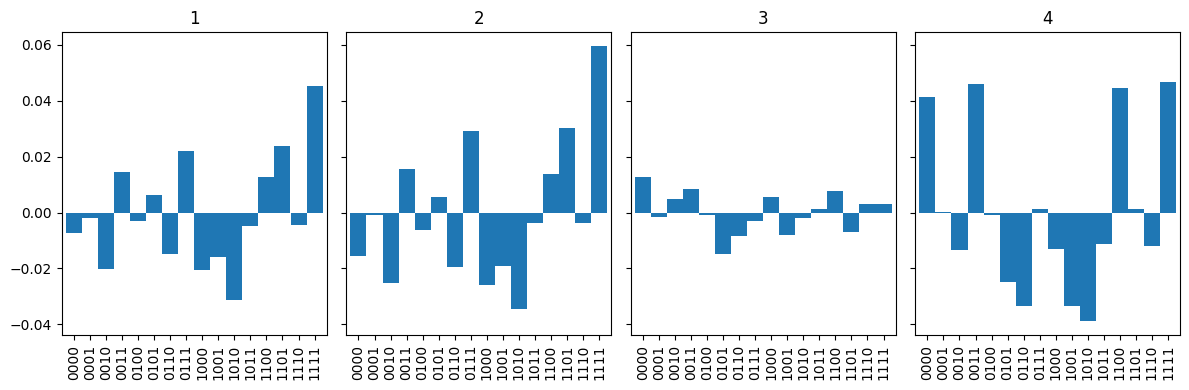

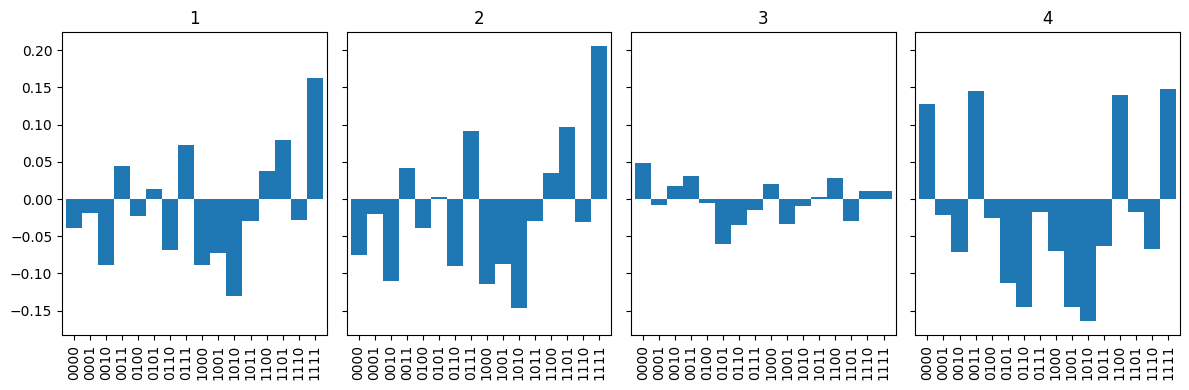

In [28]:
# plot proportions minus average

# uniform bitstring vector under level-l norm
def uniform(bits=window_size, l=1):
    keys = np.norm([ 1 ] * (2 ** bits), l)
    name = [
        f'{i:0{bits}b}'
        for i in range(2 ** bits)
    ]
    return pd.Series(keys, index = name).T

# probability sum = 1 vector
plot4b(bitstrings, lambda s: np.norm(s.value_counts(), l=1) - uniform(l=1))

# "normal" vector
plot4b(bitstrings, lambda s: np.norm(s.value_counts(), l=2) - uniform(l=2))

helpful formulae
![mean/stddev](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic.wixstatic.com%2Fmedia%2F4c04a2_1e9815ff4ec54f14ad22fa5f526269a9~mv2.png%2Fv1%2Ffill%2Fw_980%2Ch_283%2Cal_c%2Cq_85%2Cusm_0.66_1.00_0.01%2Cenc_auto%2F4c04a2_1e9815ff4ec54f14ad22fa5f526269a9~mv2.png&f=1&nofb=1&ipt=36b6f005fa10ded28bbfdc26a3c98ee6c74b23c00c1497add08eb53712b48b9f&ipo=images)

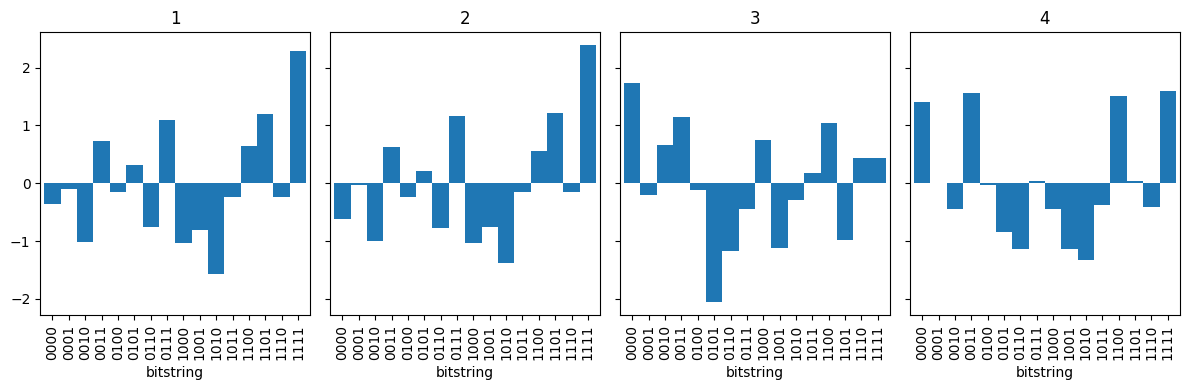

In [30]:
# maybe better scaling: Z(/t?)-scores
plot4b(bitstrings, lambda s: (s.value_counts() - s.value_counts().mean()) / s.value_counts().std())

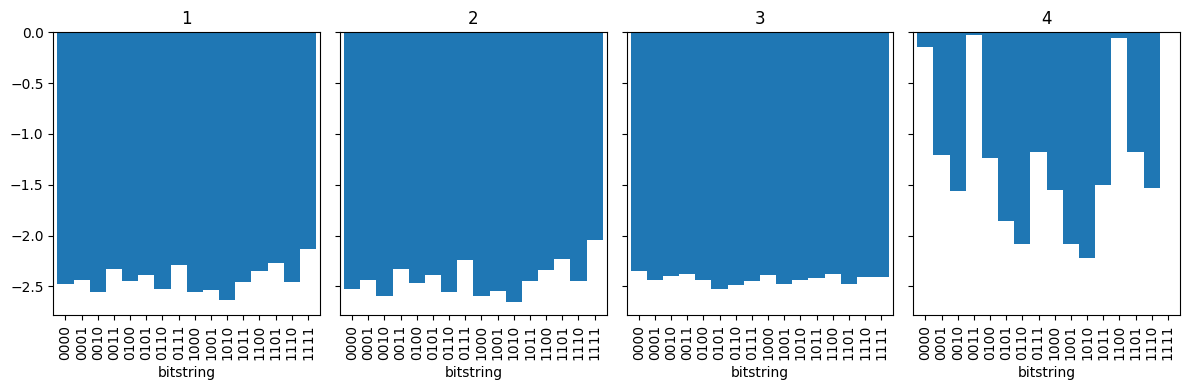

In [31]:
# i lost track of this

summ = pd.concat(bitstrings.values()).reset_index().bitstring
std = summ.value_counts().std()
# std = sum([
#     df.bitstring.value_counts().std() ** 2 / len(df.bitstring)
#     for (i,df) in dfi.items()
# ])
n = len(summ)
# n = sum([
#     len(df.bitstring)
#     for (i,df) in dfi.items()
# ])
mean = summ.value_counts().mean()
#sum([
    #df.bitstring.value_counts().mean()
    #/ len(df.bitstring.value_counts())
    #for (i,df) in dfi.items()
#]) * 
[mean, std, n]
plot4b(bitstrings, lambda s: (s.value_counts() - mean) / std)